# HUMAN ACTIVITY RECOGNITION USING MULTICHANNEL CNN

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import fft
from scipy.fftpack import fft
#import welch
from scipy.signal import welch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, MaxPooling1D, concatenate, Dropout, BatchNormalization
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
# File paths
file_paths = {
    'total_acc_x': '../UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt',
    'total_acc_y': '../UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt',
    'total_acc_z': '../UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt',
    'body_acc_x': '../UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt',
    'body_acc_y': '../UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt',
    'body_acc_z': '../UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt',
    'body_gyro_x': '../UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt',
    'body_gyro_y': '../UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt',
    'body_gyro_z': '../UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt'
}

features = {}

# Process each file
for key, file_path in file_paths.items():
    
    # Load the data
    data = np.loadtxt(file_path)
    
    # Calculate the features
    features[key] = data

In [3]:
y_train = np.loadtxt('../UCI HAR Dataset/train/y_train.txt')

In [4]:
y_train[0:100]

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## EDA

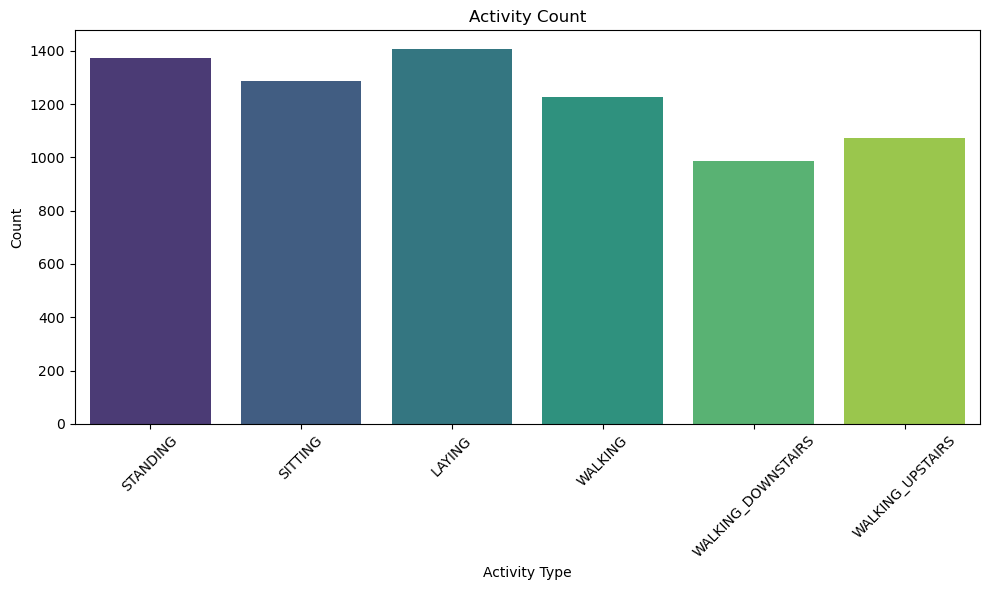

In [6]:
# Let's create a count plot for the provided array using seaborn.

# Sample array data provided by the user:
activity_array = y_train
# Mapping of the activity numbers to descriptive names:
activity_mapping = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

# Convert the numerical activity labels in the array to descriptive names:
activity_labels = [activity_mapping.get(activity, 'Unknown') for activity in activity_array]

# Now, create the count plot with seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x=activity_labels, palette='viridis')
plt.title('Activity Count')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate the x labels to show them better
plt.tight_layout()
plt.savefig('./plot/activity_count.png', dpi=300)
plt.show()


In [11]:
features

{'total_acc_x': array([[1.012817 , 1.022833 , 1.022028 , ..., 1.018445 , 1.019372 ,
         1.021171 ],
        [1.018851 , 1.02238  , 1.020781 , ..., 1.014788 , 1.016499 ,
         1.017849 ],
        [1.023127 , 1.021882 , 1.019178 , ..., 1.021041 , 1.022935 ,
         1.022019 ],
        ...,
        [0.7548917, 0.8043137, 0.831714 , ..., 0.6956257, 0.7479103,
         0.776768 ],
        [0.9279268, 0.9129872, 0.9246597, ..., 0.6753473, 0.6603377,
         0.719353 ],
        [0.7980909, 0.8192417, 0.8658821, ..., 0.8980947, 0.8283723,
         0.8002428]]),
 'total_acc_y': array([[-0.1232167, -0.1268756, -0.1240037, ..., -0.1240696, -0.1227451,
         -0.121326 ],
        [-0.123976 , -0.1268078, -0.1277862, ..., -0.1290268, -0.1264244,
         -0.1305193],
        [-0.1200157, -0.1214994, -0.1228407, ..., -0.1308757, -0.1312099,
         -0.1301826],
        ...,
        [-0.1711829, -0.1999375, -0.2319457, ..., -0.2217656, -0.2811496,
         -0.3275988],
        [-0.223801

In [12]:
features["body_acc_x"].shape

(7352, 128)

In [8]:
# Function to plot a window of sensor data
def plot_sensor_window(sensor_data_x, sensor_data_y, sensor_data_z, sensor_name, activity_name, reading_num):
        
    plt.figure(figsize=(7, 4))
    plt.plot(sensor_data_x, 'purple', label="X axis")
    plt.plot(sensor_data_y, 'g', label="Y axis")
    plt.plot(sensor_data_z, 'orange', label="Z axis")
    plt.title(f'{sensor_name} Reading {reading_num} for {activity_name}')
    plt.xlabel('Reading')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'plot/{sensor_name}_{activity_name}_{reading_num}_plot.png', dpi=300)
    plt.show()

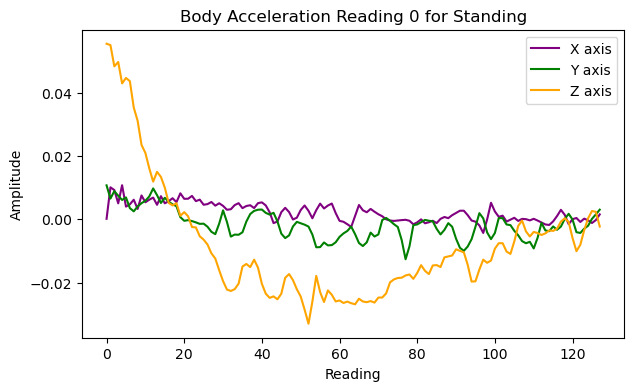

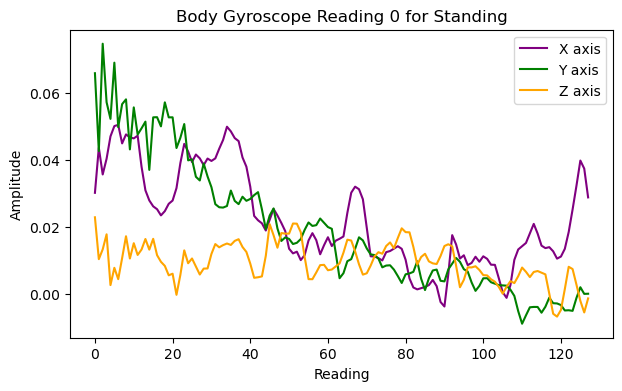

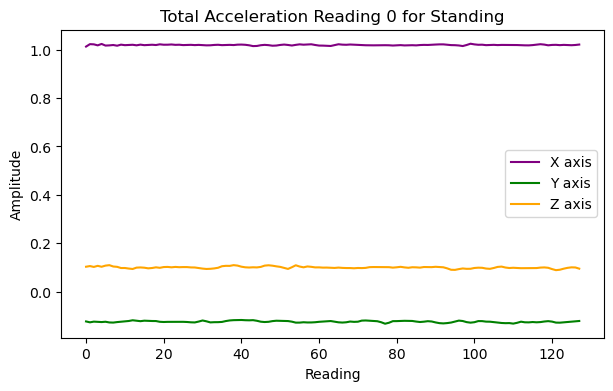

In [9]:
# Plotting one window of data for each sensor type
plot_sensor_window(features['body_acc_x'][0], features['body_acc_y'][0], features['body_acc_z'][0], 'Body Acceleration', 'Standing', 0)
plot_sensor_window(features['body_gyro_x'][0], features['body_gyro_y'][0], features['body_gyro_z'][0], 'Body Gyroscope', 'Standing', 0)
plot_sensor_window(features['total_acc_x'][0], features['total_acc_y'][0], features['total_acc_z'][0], 'Total Acceleration', 'Standing', 0)

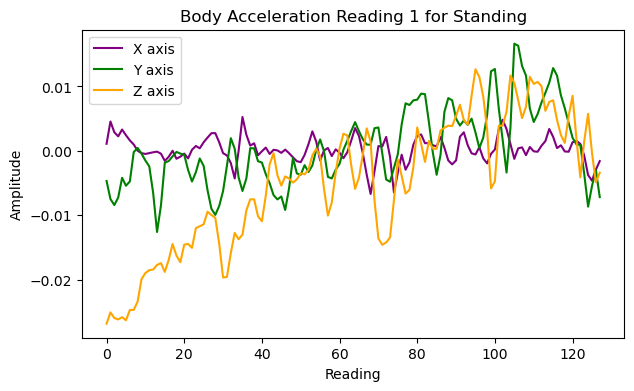

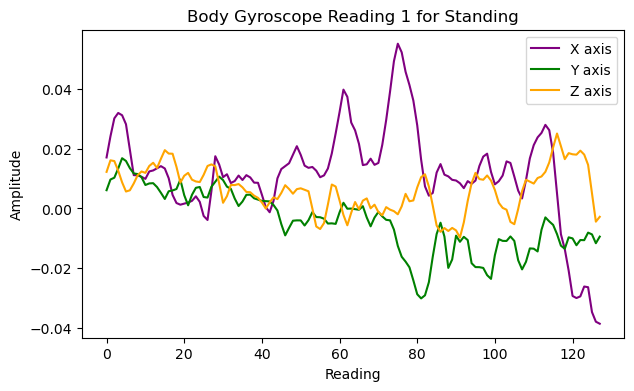

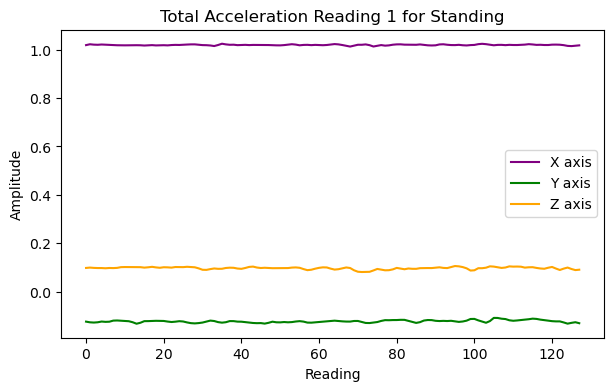

In [10]:
# Plotting one window of data for each sensor type
plot_sensor_window(features['body_acc_x'][1], features['body_acc_y'][1], features['body_acc_z'][1], 'Body Acceleration', 'Standing', 1)
plot_sensor_window(features['body_gyro_x'][1], features['body_gyro_y'][1], features['body_gyro_z'][1], 'Body Gyroscope', 'Standing', 1)
plot_sensor_window(features['total_acc_x'][1], features['total_acc_y'][1], features['total_acc_z'][1], 'Total Acceleration', 'Standing', 1)

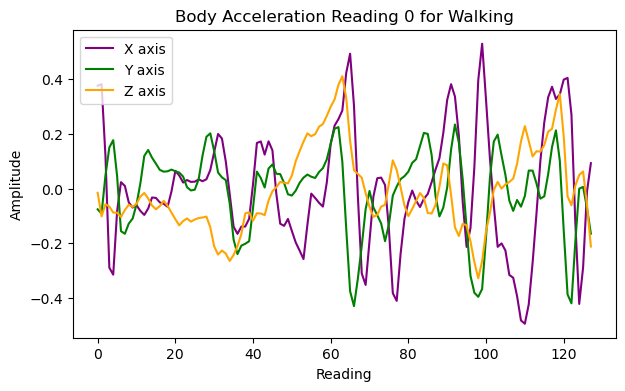

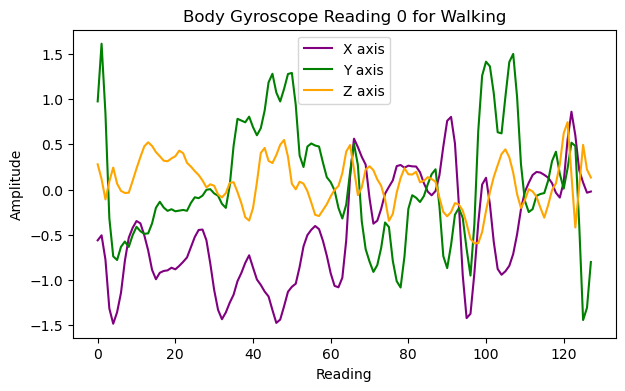

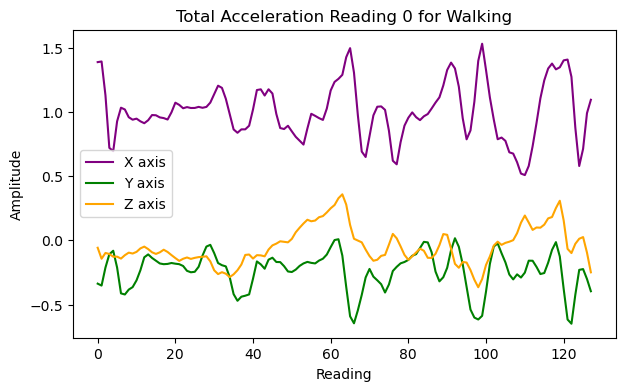

In [11]:
# Plotting one window of data for each sensor type
plot_sensor_window(features['body_acc_x'][78], features['body_acc_y'][78], features['body_acc_z'][78], 'Body Acceleration', "Walking", 0)
plot_sensor_window(features['body_gyro_x'][78], features['body_gyro_y'][78], features['body_gyro_z'][78], 'Body Gyroscope', "Walking", 0)
plot_sensor_window(features['total_acc_x'][78], features['total_acc_y'][78], features['total_acc_z'][78], 'Total Acceleration', "Walking", 0)

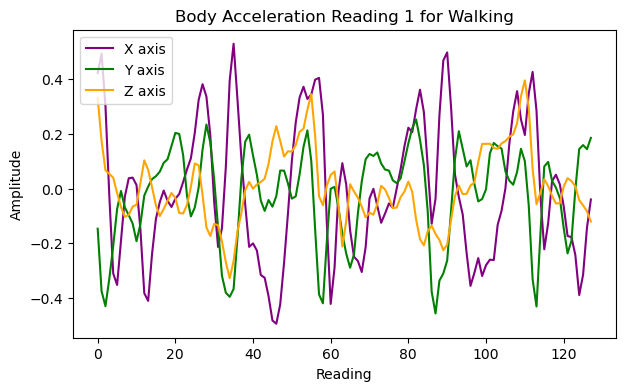

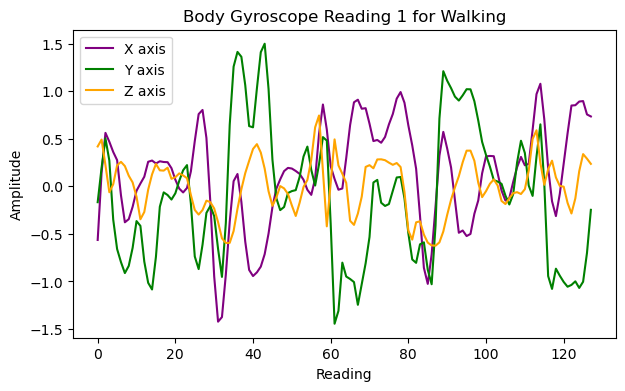

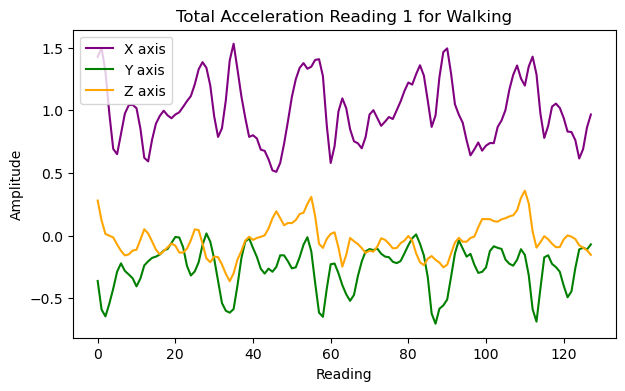

In [12]:
# Plotting one window of data for each sensor type
plot_sensor_window(features['body_acc_x'][79], features['body_acc_y'][79], features['body_acc_z'][79], 'Body Acceleration', "Walking", 1)
plot_sensor_window(features['body_gyro_x'][79], features['body_gyro_y'][79], features['body_gyro_z'][79], 'Body Gyroscope', "Walking", 1)
plot_sensor_window(features['total_acc_x'][79], features['total_acc_y'][79], features['total_acc_z'][79], 'Total Acceleration', "Walking", 1)

## Feature Engineering

### Converting to Frequency and Power features

In [18]:
def calculate_freq_power(array, fs=50):
    
    # Initialize lists to hold frequency and power features
    frequency_features = []
    power_features = []

    # Loop over each sample in the dataset
    for sample in array:
        # Apply FFT to get frequency features
        freq_data = fft(sample)
        # Take the absolute value to get the magnitude
        freq_magnitude = np.abs(freq_data)
        frequency_features.append(freq_magnitude)
        
        # Apply Welch's method to get power spectral density, which are the power features
        frequencies, power_density = welch(sample, fs=fs)
        power_features.append(power_density)

    # Convert lists to numpy arrays
    frequency_features = np.array(frequency_features)
    power_features = np.array(power_features)
    
    return frequency_features, power_features

In [20]:
# File paths
file_paths = {
    'total_acc_x': '../UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt',
    'total_acc_y': '../UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt',
    'total_acc_z': '../UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt',
    'body_acc_x': '../UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt',
    'body_acc_y': '../UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt',
    'body_acc_z': '../UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt',
    'body_gyro_x': '../UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt',
    'body_gyro_y': '../UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt',
    'body_gyro_z': '../UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt'
}

# Initialize dictionaries to hold the frequency and power features
frequency_features = {}
power_features = {}

# Process each file
for key, file_path in file_paths.items():
    
    # Load the data
    data = np.loadtxt(file_path)
    
    # Calculate the frequency and power features
    frequency_features[key], power_features[key] = calculate_freq_power(data)

## DATA PREPROCESSING

In [21]:
def reshape_features(frequency_features, power_features, axes=('x', 'y', 'z')):
    # Initialize lists to collect the reshaped features
    reshaped_freq_features = []
    reshaped_power_features = []
    
    # For each axis, we will concatenate the frequency features and power features separately
    for axis in axes:
        freq_axis_features = np.concatenate([frequency_features[f'total_acc_{axis}'],
                                             frequency_features[f'body_acc_{axis}'],
                                             frequency_features[f'body_gyro_{axis}']], axis=1)
        power_axis_features = np.concatenate([power_features[f'total_acc_{axis}'],
                                              power_features[f'body_acc_{axis}'],
                                              power_features[f'body_gyro_{axis}']], axis=1)
        
        # Reshape to add a channel dimension
        freq_axis_features = freq_axis_features[..., np.newaxis]
        power_axis_features = power_axis_features[..., np.newaxis]
        
        reshaped_freq_features.append(freq_axis_features)
        reshaped_power_features.append(power_axis_features)
    
    # Stack the features for all axes
    stacked_freq_features = np.stack(reshaped_freq_features, axis=-2)
    stacked_power_features = np.stack(reshaped_power_features, axis=-2)
    
    return stacked_freq_features, stacked_power_features

# Now call the function with feature dictionaries
frequency_features_stacked, power_features_stacked = reshape_features(frequency_features, power_features)

# Check the shapes to ensure they are correct
print(frequency_features_stacked.shape)
print(power_features_stacked.shape)

(7352, 384, 3, 1)
(7352, 195, 3, 1)


In [22]:
y_train = np.loadtxt('../UCI HAR Dataset/train/y_train.txt')
y_train_adjusted = y_train - 1
train_labels_one_hot = tf.keras.utils.to_categorical(y_train_adjusted, num_classes=6)

In [114]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, concatenate

# from tensorflow.keras.layers import Conv1D, MaxPooling1D

# # Define the model input shapes based on your features
# frequency_input_shape = frequency_features_stacked.shape[1:3]  # e.g., (384, 3)
# power_input_shape = power_features_stacked.shape[1:3]  # e.g., (195, 3)
# number_of_classes = 6  # Number of classification categories

# # CNN for frequency features
# frequency_input = Input(shape=frequency_input_shape)
# freq_conv1 = Conv1D(16, kernel_size=3, activation='relu')(frequency_input)
# freq_conv2 = Conv1D(16, kernel_size=3, activation='relu')(freq_conv1)
# freq_pool = MaxPooling1D(pool_size=2)(freq_conv2)
# freq_flat = Flatten()(freq_pool)

# # CNN for power features
# power_input = Input(shape=power_input_shape)
# power_conv1 = Conv1D(16, kernel_size=3, activation='relu')(power_input)
# power_conv2 = Conv1D(16, kernel_size=3, activation='relu')(power_conv1)
# power_pool = MaxPooling1D(pool_size=2)(power_conv2)
# power_flat = Flatten()(power_pool)

# # Concatenate the outputs of the two channels
# concatenated = concatenate([freq_flat, power_flat])

# # Dense layer for classification
# dense = Dense(units=64, activation='relu')(concatenated)
# output = Dense(units=number_of_classes, activation='softmax')(dense)

# # Create the model
# model = Model(inputs=[frequency_input, power_input], outputs=output)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Model Building

In [76]:
# Define the model input shapes based on your features
frequency_input_shape = frequency_features_stacked.shape[1:3]  # e.g., (384, 3)
power_input_shape = power_features_stacked.shape[1:3]  # e.g., (195, 3)
number_of_classes = 6  # Number of classification categories

# CNN for frequency features
frequency_input = Input(shape=frequency_input_shape)
freq_conv1 = Conv1D(32, kernel_size=3, activation='relu')(frequency_input)
freq_bn1 = BatchNormalization()(freq_conv1)
freq_pool1 = MaxPooling1D(pool_size=2)(freq_bn1)
freq_conv2 = Conv1D(32, kernel_size=3, activation='relu')(freq_pool1)
freq_bn2 = BatchNormalization()(freq_conv2)
freq_pool2 = MaxPooling1D(pool_size=2)(freq_bn2)
freq_flat = Flatten()(freq_pool2)

# CNN for power features
power_input = Input(shape=power_input_shape)
power_conv1 = Conv1D(32, kernel_size=3, activation='relu')(power_input)
power_bn1 = BatchNormalization()(power_conv1)
power_pool1 = MaxPooling1D(pool_size=2)(power_bn1)
power_conv2 = Conv1D(32, kernel_size=3, activation='relu')(power_pool1)
power_bn2 = BatchNormalization()(power_conv2)
power_pool2 = MaxPooling1D(pool_size=2)(power_bn2)
power_flat = Flatten()(power_pool2)

# Concatenate the outputs of the two channels
concatenated = concatenate([freq_flat, power_flat])

# Dense layers for classification
dense1 = Dense(units=128, activation='relu')(concatenated)
dropout1 = Dropout(0.5)(dense1)
output = Dense(units=number_of_classes, activation='softmax')(dropout1)

# Create the model
model = Model(inputs=[frequency_input, power_input], outputs=output)

# Define a higher learning rate
learning_rate = 0.001

# Create the Adam optimizer with the higher learning rate
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Rest of your model code remains the same...

# Compile the model with the custom optimizer
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 3)]             0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 195, 3)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 382, 32)              320       ['input_3[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 193, 32)              320       ['input_4[0][0]']             
                                                                                            

## Model Fitting

In [79]:
# Train the model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit([frequency_features_stacked, power_features_stacked], train_labels_one_hot, 
          epochs=100, batch_size=16, validation_split=0.2, verbose=2, shuffle=True)

Epoch 1/100


2023-12-01 13:36:35.020596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


368/368 - 47s - loss: 0.2857 - accuracy: 0.9175 - val_loss: 0.3397 - val_accuracy: 0.8586 - 47s/epoch - 126ms/step
Epoch 2/100
368/368 - 34s - loss: 0.2452 - accuracy: 0.9277 - val_loss: 0.3834 - val_accuracy: 0.8640 - 34s/epoch - 92ms/step
Epoch 3/100
368/368 - 34s - loss: 0.2193 - accuracy: 0.9400 - val_loss: 2.9966 - val_accuracy: 0.6390 - 34s/epoch - 93ms/step
Epoch 4/100
368/368 - 33s - loss: 0.2360 - accuracy: 0.9398 - val_loss: 1.0530 - val_accuracy: 0.8158 - 33s/epoch - 91ms/step
Epoch 5/100
368/368 - 34s - loss: 0.2107 - accuracy: 0.9417 - val_loss: 0.2667 - val_accuracy: 0.9082 - 34s/epoch - 93ms/step
Epoch 6/100
368/368 - 34s - loss: 0.2151 - accuracy: 0.9485 - val_loss: 0.2202 - val_accuracy: 0.9511 - 34s/epoch - 93ms/step
Epoch 7/100
368/368 - 33s - loss: 0.1779 - accuracy: 0.9544 - val_loss: 0.4832 - val_accuracy: 0.8566 - 33s/epoch - 91ms/step
Epoch 8/100
368/368 - 34s - loss: 0.2342 - accuracy: 0.9451 - val_loss: 0.2709 - val_accuracy: 0.9409 - 34s/epoch - 93ms/step
Epo

## Model Evaluation

In [82]:
history = model.history.history

df = pd.DataFrame(history)

In [84]:
df.columns = ["Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]

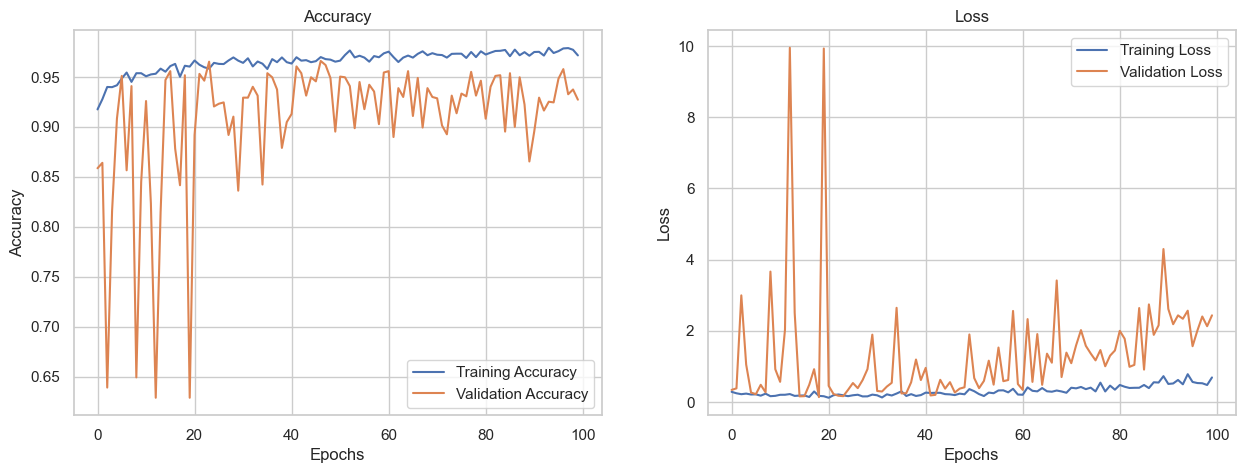

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(ax=axes[0], x=df.index, y=df['Training Accuracy'], label='Training Accuracy')
sns.lineplot(ax=axes[0], x=df.index, y=df['Validation Accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

sns.lineplot(ax=axes[1], x=df.index, y=df['Training Loss'], label='Training Loss')
sns.lineplot(ax=axes[1], x=df.index, y=df['Validation Loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

## Test Data

In [93]:
# File paths
file_paths = {
    'total_acc_x': '../UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt',
    'total_acc_y': '../UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt',
    'total_acc_z': '../UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt',
    'body_acc_x': '../UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt',
    'body_acc_y': '../UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt',
    'body_acc_z': '../UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt',
    'body_gyro_x': '../UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt',
    'body_gyro_y': '../UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt',
    'body_gyro_z': '../UCI HAR Dataset/test/Inertial Signals/body_gyro_z_test.txt'
}

# Initialize dictionaries to hold the frequency and power features
frequency_features = {}
power_features = {}

# Process each file
for key, file_path in file_paths.items():
    
    # Load the data
    data = np.loadtxt(file_path)
    
    # Calculate the frequency and power features
    frequency_features[key], power_features[key] = calculate_freq_power(data)

In [94]:
import numpy as np

def reshape_features(frequency_features, power_features, axes=('x', 'y', 'z')):
    # Initialize lists to collect the reshaped features
    reshaped_freq_features = []
    reshaped_power_features = []
    
    # For each axis, we will concatenate the frequency features and power features separately
    for axis in axes:
        freq_axis_features = np.concatenate([frequency_features[f'total_acc_{axis}'],
                                             frequency_features[f'body_acc_{axis}'],
                                             frequency_features[f'body_gyro_{axis}']], axis=1)
        power_axis_features = np.concatenate([power_features[f'total_acc_{axis}'],
                                              power_features[f'body_acc_{axis}'],
                                              power_features[f'body_gyro_{axis}']], axis=1)
        
        # Reshape to add a channel dimension
        freq_axis_features = freq_axis_features[..., np.newaxis]
        power_axis_features = power_axis_features[..., np.newaxis]
        
        reshaped_freq_features.append(freq_axis_features)
        reshaped_power_features.append(power_axis_features)
    
    # Stack the features for all axes
    stacked_freq_features = np.stack(reshaped_freq_features, axis=-2)
    stacked_power_features = np.stack(reshaped_power_features, axis=-2)
    
    return stacked_freq_features, stacked_power_features

# Now call the function with your feature dictionaries
frequency_features_stacked, power_features_stacked = reshape_features(frequency_features, power_features)

# Check the shapes to ensure they are correct
print(frequency_features_stacked.shape)
print(power_features_stacked.shape)

(2947, 384, 3, 1)
(2947, 195, 3, 1)


In [96]:
y_test = np.loadtxt('../UCI HAR Dataset/test/y_test.txt')
y_test_adjusted = y_test - 1
test_labels_one_hot = tf.keras.utils.to_categorical(y_test_adjusted, num_classes=6)

In [103]:
predictions = model.predict([frequency_features_stacked, power_features_stacked])

2023-12-01 14:40:21.209344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 4s 20ms/step


In [104]:
predictions

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12604155e-17,
        1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.27434011e-36,
        1.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]], dtype=float32)

/Users/rd/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


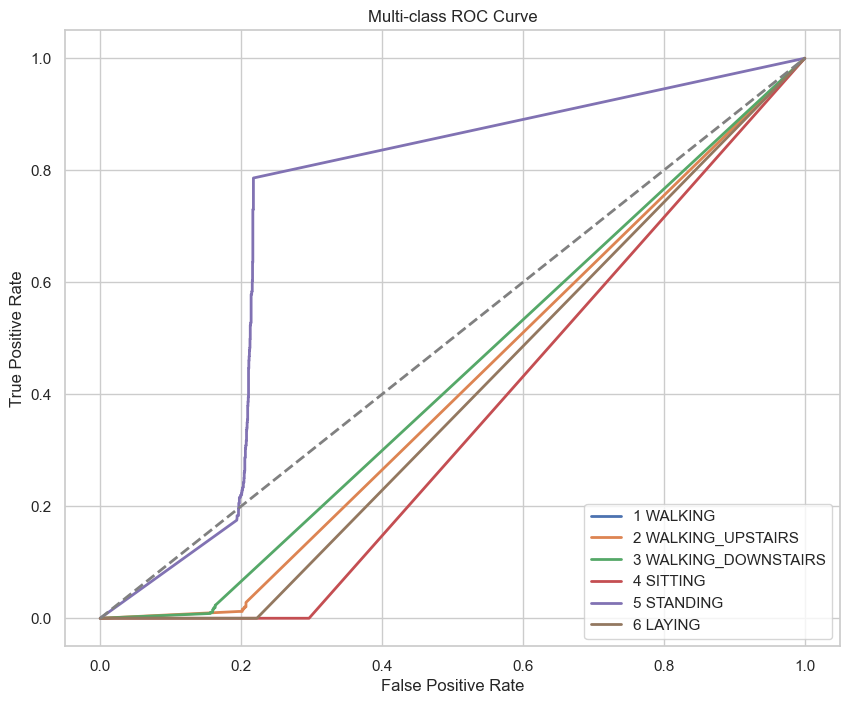

In [105]:
# Ensure you have your test data: X_test_reshaped, y_test
# y_test should be the true class labels

# Predict the probabilities for each class
y_score = predictions

# Binarize the test labels
n_classes = 6  # Assuming y_train_encoded is one-hot encoded
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
activity_labels = ['1 WALKING', '2 WALKING_UPSTAIRS', '3 WALKING_DOWNSTAIRS', 
                   '4 SITTING', '5 STANDING', '6 LAYING']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{activity_labels[i]}')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()
